# Laboratorium 3 - segmentacje

## Przygotowanie

 * pobierz i wypakuj dataset: https://data.world/socialmediadata/beeradvocate
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install gensim==3.8.3 scikit-learn==1.3.2 wordcloud==1.8.1`

## Część 1. - przygotowanie danych

In [1]:
# importujemy potrzebne pakiety

from collections import Counter, defaultdict
import codecs
import csv

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import HDBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from wordcloud import WordCloud

In [2]:
PATH = "socialmediadata-beeradvocate/data/beer_reviews.csv"
SCORE_THRESHOLD = 4  # recenzje z co najmniej taka ocena wezmiemy pod uwage
VECTOR_SIZE = 20  # jak dlugie powinny byc wektory osadzen uzytkownikow
SEGMENTS_COUNT = 10

In [3]:
# wczytujemy dane


def parse_headers(column_names):
    beer_id_column = column_names.index("beer_beerid")
    beer_style_column = column_names.index("beer_style")
    user_id_column = column_names.index("review_profilename")
    score_column = column_names.index("review_overall")
    return beer_id_column, beer_style_column, user_id_column, score_column


def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return (
        line[beer_id_column],
        line[beer_style_column],
        line[user_id_column],
        float(line[score_column]),
    )


def read_and_parse_reviews(path, score_threshold):
    with codecs.open(PATH, "r", "UTF-8") as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(
            next(datareader)
        )

        users_favourite_beers = defaultdict(list)
        for review in datareader:
            beer_id, _, user_id, score = parse_review(
                review, beer_id_column, beer_style_column, user_id_column, score_column
            )
            if score >= score_threshold:
                users_favourite_beers[user_id].append(beer_id)

    return users_favourite_beers


def get_beer_id_to_style_mapping(path):
    with codecs.open(PATH, "r", "UTF-8") as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(
            next(datareader)
        )
        beer_styles = {}
        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(
                review, beer_id_column, beer_style_column, user_id_column, score_column
            )
            beer_styles[beer_id] = beer_style
        return beer_styles


# otrzymujemy slownik - mapowanie z user_id na liste ulubionych beer_ids
users_favourite_beers = read_and_parse_reviews(PATH, SCORE_THRESHOLD)

# dodatkowo przygotujmy sobie slownik mapujacy id piwa na nazwe stylu
beer_styles = get_beer_id_to_style_mapping(PATH)

## Część 2. - osadzenia użytkowników

In [4]:
# trenujemy model osadzajacy piwa i uzytkownikow w przestrzeni

model = Word2Vec(
    sentences=users_favourite_beers.values(),
    vector_size=VECTOR_SIZE,
    window=5,
    min_count=1,
    workers=4,
)

In [5]:
users_favourite_beers["johnmichaelsen"]  # list of favourite John's favorites beers

['64883',
 '56980',
 '56115',
 '33624',
 '33624',
 '47695',
 '4373',
 '55614',
 '47658',
 '47658',
 '21822',
 '21822',
 '20478',
 '20478',
 '11757',
 '16074',
 '49077',
 '59966',
 '54827',
 '47659',
 '24905',
 '19960',
 '19960',
 '41843',
 '3606',
 '1324',
 '54731',
 '54731',
 '21704',
 '73411',
 '429',
 '21483',
 '5487',
 '5411',
 '5411',
 '30213',
 '1058',
 '50886',
 '50849',
 '10572',
 '39721',
 '45794',
 '42878',
 '42878',
 '70981',
 '52367',
 '58118',
 '42433',
 '46983',
 '53728',
 '47954',
 '70892',
 '67471',
 '43889',
 '58117',
 '74491',
 '51557',
 '53134',
 '53134',
 '1959',
 '48387',
 '56716',
 '56716',
 '59162',
 '67931',
 '51176',
 '46964',
 '48434',
 '44457',
 '66827',
 '67106',
 '52371',
 '40492',
 '74167',
 '37477',
 '283',
 '42533',
 '2671',
 '74166',
 '71968',
 '52142',
 '1904',
 '53666',
 '55243',
 '72967',
 '67230',
 '74634',
 '276',
 '44749',
 '30420',
 '52574',
 '54089',
 '6549',
 '62328',
 '30956',
 '73314',
 '30955',
 '30955',
 '47169',
 '47600',
 '65771',
 '21897

In [6]:
model.wv[users_favourite_beers["johnmichaelsen"][0]]

array([ 0.05650723,  0.0012852 , -0.02245579, -0.02423018,  0.01736221,
       -0.05470539,  0.05133418, -0.00215428,  0.03429325, -0.02388108,
        0.01800819,  0.00335584, -0.03077242,  0.0355004 ,  0.0153568 ,
        0.01854455, -0.00640038,  0.01624576, -0.00269351,  0.04071996],
      dtype=float32)

In [7]:
# na podstawie modelu obliczamy wektorowa reprezentacje uzytkownikow


def get_mean_vector_for_user(user_favourite_beers, model, vector_size):
    # inicjalizujemy wektor zerami
    v = np.zeros(vector_size)

    for beer in user_favourite_beers:
        v = v + model.wv[beer]

    v = v / len(user_favourite_beers)
    return v


def get_mean_user_vectors(users_favourite_beers, model, vector_size):
    # korzystajac z powyzszej funkcji, tworzymy slownik {user_id -> vector}
    mean_users_vectors = {
        user_id: get_mean_vector_for_user(
            users_favourite_beers[user_id], model, vector_size
        )
        for user_id in users_favourite_beers
        if len(users_favourite_beers[user_id]) > 0
    }

    return mean_users_vectors


user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

## Część 3. - klasteryzacja

In [8]:
# klastrujemy uzytkownikow - mozemy uzyc wielu algorytmow, np k-means, agglomerative, BIRCH, ...


def get_users_segmentation(
    user_vectors, vector_size, segments_count, clustering_algorithm
):
    # rozkladamy slownik user_vectors na liste uzytkownikow i liste wektorow
    #  - wazne jest zachowanie tej samej kolejnosci w obu listach
    users = list(user_vectors.keys())
    vectors = list(user_vectors.values())

    # zamieniamy liste wektorow w macierz
    users_array = np.stack(vectors, axis=0)
    # zaimplementuj wsparcie dla co najmniej jednego algorytmu wiecej
    if clustering_algorithm == "agglomerative":
        clustering = AgglomerativeClustering(n_clusters=segments_count).fit_predict(
            users_array
        )
        # clustering to lista przypisanych klastrow - i-ty element to klaster, do ktorego nalezy i-ty wektor

    if clustering_algorithm == "hdbscan":
        clustering = HDBSCAN(min_cluster_size=30, min_samples = 5).fit_predict(
            users_array
        )

    segmentation = {
        user_id: cluster_id for user_id, cluster_id in zip(users, clustering) if cluster_id != -1
    }

    for user_id, cluster_id in zip(users, clustering):
        if cluster_id == -1:
            del user_vectors[user_id]
            del users_favourite_beers[user_id]
    # jesli nie pomieszalismy kolejnosci w listach, to mozemy odzyskac mapping user_id -> cluster

    return segmentation


segmentation = get_users_segmentation(
    user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, "hdbscan"
)

In [9]:
segmentation

{'johnmichaelsen': 47,
 'LordAdmNelson': 47,
 'augustgarage': 47,
 'Halcyondays': 47,
 'beerguy101': 47,
 'UCLABrewN84': 47,
 'zaphodchak': 47,
 'Tilley4': 47,
 'dbmernin83': 47,
 'titosupertramp': 47,
 'optimator13': 47,
 'Blakaeris': 47,
 'bashiba': 47,
 'Klym': 47,
 'flexabull': 47,
 'Bung': 47,
 'oberon': 47,
 't420o': 47,
 'DarthKostrizer': 47,
 'MrVonzipper': 47,
 'TheWhiskerReview': 47,
 'Jason': 47,
 'DoubleJ': 47,
 'Deuane': 47,
 'Mattybeerguy': 47,
 'micromaniac129': 47,
 'northyorksammy': 47,
 'vette2006c5r': 47,
 'djeucalyptus': 47,
 'ccrida': 47,
 'brewandbbq': 47,
 'hopsbreath': 47,
 'Slatetank': 47,
 'Proteus93': 47,
 'SShelly': 47,
 'zoso1967': 47,
 'msubulldog25': 47,
 'NJpadreFan': 47,
 'd0ggnate': 47,
 'Cyberkedi': 47,
 'mdagnew': 47,
 'mikesgroove': 47,
 'hdofu': 47,
 'GratefulBeerGuy': 47,
 'PDXHops': 47,
 'Goliath': 47,
 'zeff80': 47,
 'akorsak': 47,
 'wchesak': 47,
 'dyan': 47,
 'HopDerek': 47,
 'maximum12': 47,
 'JayQue': 47,
 'bbothen': 47,
 'Kegatron': 47,
 'C

In [10]:
# obliczamy licznosci segmentow

def get_segment_sizes(segmentation):
    return Counter(segmentation.values())


sizes = get_segment_sizes(segmentation)
SEGMENTS_COUNT = len(sizes.keys())  # na ile segmentow chcemy podzielic populacje uzytkownikow
sizes

Counter({47: 7679,
         45: 34,
         33: 56,
         30: 38,
         28: 33,
         19: 61,
         21: 38,
         22: 53,
         32: 53,
         24: 58,
         4: 37,
         41: 99,
         40: 66,
         48: 35,
         1: 60,
         7: 46,
         8: 34,
         35: 49,
         29: 31,
         34: 64,
         23: 48,
         20: 54,
         15: 41,
         16: 36,
         17: 37,
         18: 31,
         25: 37,
         27: 41,
         36: 50,
         11: 66,
         10: 87,
         14: 52,
         42: 32,
         5: 67,
         46: 34,
         43: 109,
         44: 89,
         26: 47,
         37: 66,
         0: 40,
         12: 38,
         38: 67,
         39: 34,
         3: 31,
         6: 34,
         31: 31,
         13: 30,
         9: 51,
         2: 31})

In [11]:
# obliczamy metryke jakosci segmentacji
# metryka przyjmuje wartosci [-1, 1] - im wiecej, tym lepiej
users, user_vectors_list = zip(*user_vectors.items())
segments_list = [segmentation[u] for u in users]

mean_silhouette = silhouette_score(user_vectors_list, segments_list, metric="euclidean")
per_sample_silhouettes = silhouette_samples(
    user_vectors_list, segments_list, metric="euclidean"
)

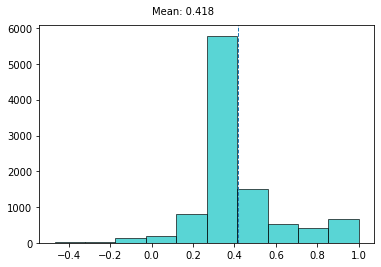

In [12]:
# rysujemy wykres
def plot_histogram(values, mean_value):
    plt.hist(values, color="c", edgecolor="k", alpha=0.65)
    plt.axvline(mean_value, linestyle="dashed", linewidth=1)
    _, plot_height = plt.ylim()
    plt.text(0, plot_height * 1.05, "Mean: {:.3f}".format(mean_value))
    plt.show()


plot_histogram(per_sample_silhouettes, mean_silhouette)

## Część 4. - opisy segmentów

In [13]:
# obliczamy popularnosc styli w segmentach oraz w calej populacji
#  - czyli jak czesto kazdy ze styli wystepowal


def get_per_segment_styles_popularity(
    users_favourite_beers, beer_styles, segmentation, segments_count
):
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]

    for user, beers in users_favourite_beers.items():
        for style in beers:
            beer_styles_per_segment[segmentation[user]][style] += 1

    return beer_styles_per_segment


def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)

    for _, beers in users_favourite_beers.items():
        for style in beers:
            total_popularity[style] += 1

    return total_popularity


per_segment_styles_popularity = get_per_segment_styles_popularity(
    users_favourite_beers, beer_styles, segmentation, SEGMENTS_COUNT
)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

per_segment_styles_popularity, total_styles_popularity

({0: defaultdict(<function __main__.get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda>()>,
              {'412': 40}),
  1: defaultdict(<function __main__.get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda>()>,
              {'1696': 12, '645': 35, '129': 15}),
  2: defaultdict(<function __main__.get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda>()>,
              {'639': 31}),
  3: defaultdict(<function __main__.get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda>()>,
              {'73': 31}),
  4: defaultdict(<function __main__.get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda>()>,
              {'248': 37}),
  5: defaultdict(<function __main__.get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda>()>,
              {'7971': 56, '22790': 10, '12770': 2}),
  6: defaultdict(<function __main__.get_per_segment_styles_popularity.<locals>.<dictcomp>.<lambda>()>,
              {'8919': 10, '34483': 13, '14712': 12}),
  7: def

In [14]:
from copy import deepcopy

# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
#   oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
#   dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}


def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    most_popular = {i: [] for i in range(len(per_segment_styles_popularity))}
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]

    for segmentd_id, segment_beers in per_segment_styles_popularity.items():
        most_popular[segmentd_id] = {
            beer_styles[style]: popularity for style, popularity in sorted(segment_beers.items(), key=lambda x: x[1], reverse=True)[:N]
        }

    return most_popular


def most_distinctive_styles_per_segment(
    total_styles_popularity, per_segment_styles_popularity, N
):
    most_distinctive = {
        i: defaultdict(lambda: 0) for i in range(len(per_segment_styles_popularity))
    }
    # do tego slownika bedziemy sie odwolywac np. tak: beer_styles_per_segment[segment][style]

    for segmentd_id, segment_beers in per_segment_styles_popularity.items():
        normalised_beers = {
            style: popularity / total_styles_popularity[style]
            for style, popularity in segment_beers.items()
        }

        most_distinctive[segmentd_id] = {
            beer_styles[style]: frequency
            for style, frequency in sorted(
                normalised_beers.items(), key=lambda x: x[1], reverse=True
            )[:N]
        }

    return most_distinctive


top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(
    total_styles_popularity, per_segment_styles_popularity, top_N
)

most_popular, most_distinctive

({0: {'Russian Imperial Stout': 40},
  1: {'Quadrupel (Quad)': 35, 'Belgian Pale Ale': 15, 'Dubbel': 12},
  2: {'English Brown Ale': 31},
  3: {'Milk / Sweet Stout': 31},
  4: {'Witbier': 37},
  5: {'American Double / Imperial IPA': 56,
   'American IPA': 10,
   'Belgian Strong Pale Ale': 2},
  6: {'Russian Imperial Stout': 13,
   'Scotch Ale / Wee Heavy': 12,
   'American Double / Imperial IPA': 10},
  7: {'Tripel': 46},
  8: {'American Amber / Red Ale': 34, 'Belgian Strong Dark Ale': 1},
  9: {'American Amber / Red Lager': 51},
  10: {'American Double / Imperial IPA': 1, 'Russian Imperial Stout': 13},
  11: {'American IPA': 36,
   'American Pale Wheat Ale': 24,
   'American Stout': 6,
   'English Brown Ale': 1},
  12: {'California Common / Steam Beer': 14,
   'American Porter': 13,
   'American Pale Ale (APA)': 12},
  13: {'Quadrupel (Quad)': 26, 'Dubbel': 6, 'Belgian Pale Ale': 2},
  14: {'Belgian Strong Pale Ale': 52, 'Oatmeal Stout': 1},
  15: {'American Strong Ale': 41},
  16: {'

## Część 5. - wizualizacja

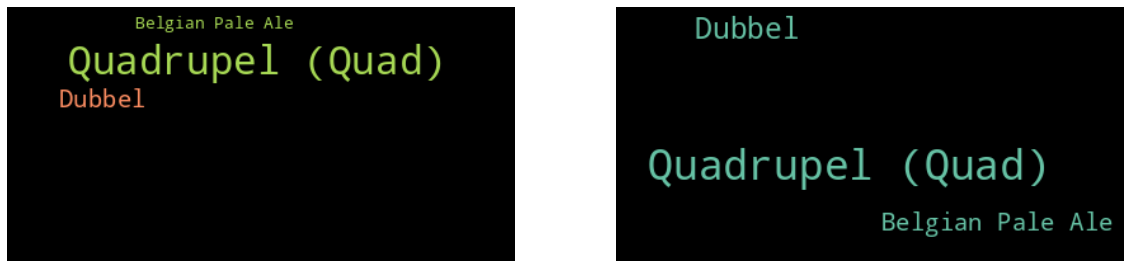

In [30]:
# teraz mozemy zwizualizowac nasze segmentacje za pomoca word clouds
#   zauwaz, jak roznia sie obie metody opisow segmentow oraz opisy miedzy poszczegolnymi segmentami


def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    wordcloud1 = WordCloud(random_state=42, background_color="black", colormap="Set2")
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(random_state=42, background_color="black", colormap="Set2")
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()


visualise_styles(most_popular, most_distinctive, 13)

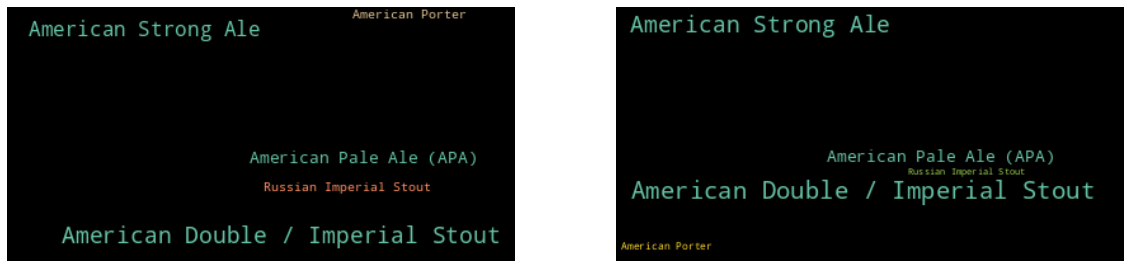

In [37]:
visualise_styles(most_popular, most_distinctive, 25)

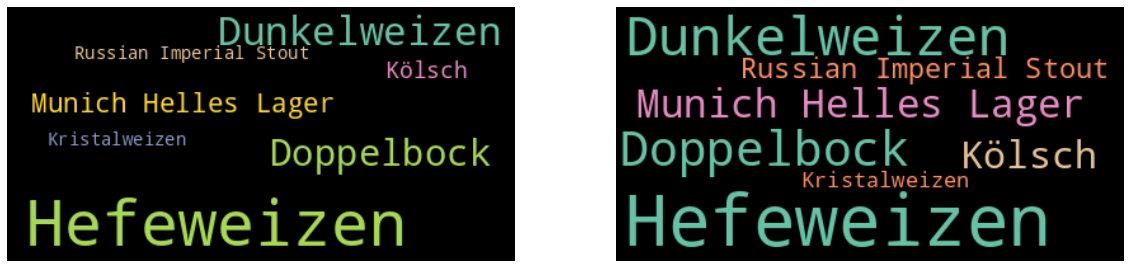

In [33]:
visualise_styles(most_popular, most_distinctive, 20)

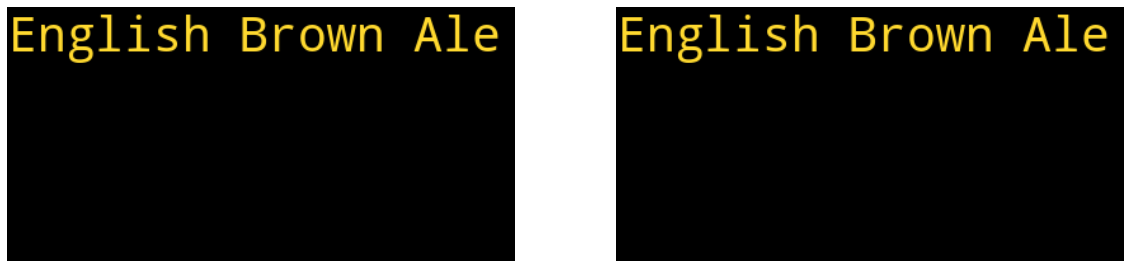

In [39]:
visualise_styles(most_popular, most_distinctive, 2)

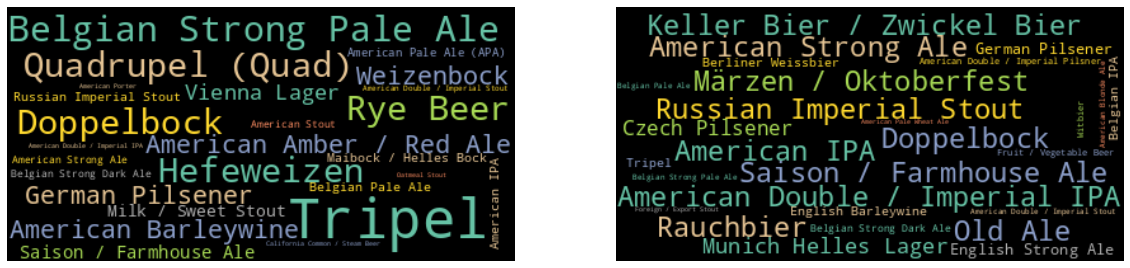

In [40]:
visualise_styles(most_popular, most_distinctive, 47)